In [1]:
%pylab
from __future__ import division
if True:
  # Import functions and libraries
  import numpy as np
  import matplotlib.pyplot as plt
  import pyaudio
  import Queue
   
  import struct
  import gzip
  import threading,time
  import sys

  from numpy import pi
  from numpy import sin
  from numpy import zeros
  from numpy import r_
  from numpy import ones
  from scipy import signal
  from scipy import integrate
  from scipy import signal, ndimage, misc, fftpack

  import threading,time
  import multiprocessing

  from numpy import mean
  from numpy import power
  from numpy.fft import fft
  from numpy.fft import fftshift
  from numpy.fft import ifft
  from numpy.fft import ifftshift
  from  scipy.io.wavfile import read as wavread
  import serial
  import ax25
  from fractions import gcd
  import bitarray
  import Transmission
%matplotlib inline


Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
IMG_DIR = 'Images/'

In [3]:
# function to compute least common multipler
def lcm(numbers):
    return reduce(lambda x, y: (x*y)/gcd(x,y), numbers, 1)


# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = floor(len(x)/N)
    x_ = reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, mean(abs(X)**2,axis=0)


# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
    fig=figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q,ctrlQ ,p, fs , dev, ser="", keydelay=0.1, chunk=1024):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # ctrlQ - A queue object for ending the thread
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    #
    #
    # There are two ways to end the thread: 
    #    1 - send "EOT" through  the control queue. This is used to terminate the thread on demand
    #    2 - send "EOT" through the data queue. This is used to terminate the thread when data is done. 
    #
    # You can also key the radio either through the data queu and the control queue
    
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        if not ctrlQ.empty():
            
            # control queue 
            ctrlmd = ctrlQ.get()
            if ctrlmd is "EOT"  :
                    ostream.stop_stream()
                    ostream.close()
                    print("Closed  play thread")
                    return;
            elif (ctrlmd is "KEYOFF"  and ser!=""):
                ser.setDTR(0)
                #print("keyoff\n")
            elif (ctrlmd is "KEYON" and ser!=""):
                ser.setDTR(1)  # key PTT
                #print("keyon\n")
                time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
                
        
        data = Q.get()
        
        if (data is "EOT") :
            ostream.stop_stream()
            ostream.close()
            print("Closed  play thread")
            return;
        elif (data is "KEYOFF"  and ser!=""):
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data is "KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue,ctrlQ, p, fs ,dev,chunk=512):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        if not ctrlQ.empty():
            ctrlmd = ctrlQ.get()          
            if ctrlmd is "EOT"  :
                istream.stop_stream()
                istream.close()
                print("Closed  record thread")
                return;
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk, exception_on_overflow = False) # read a chunk of data
        except NameError:
            print "errorError"
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list
        
def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= 1.0*fs*dt
    Ndah = 3*Ndot
    
    sdot = sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = concatenate((sig,sdah,zeros(Ndot)))
    return sig
            
    
            

def printDevNumbers(p):
    N = p.get_device_count()
    print N, 33
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name
                


In [4]:
def findPackets(bits):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
                
        flg = bitarray.bitarray([0,1,1,1,1,1,1,0])
        packets = []
        n = 0
        pktcounter = 0
        packet = []
        state = 'search'
        
        # Loop over bits
        while (n < len(bits)-7) :
            
            # default state is searching for packets
            if state is 'search':
                
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+7] == flg[1:]:
                    
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    state = 'pkt'
                    packet=flg.copy()
                    pktcounter = 8                    
                    # Advance to the end of the flag
                    n = n + 7
                else:
                    # flag was not found, advance by 1
                    n = n + 1            
        
            # state is to collect packet data. 
            elif state is 'pkt':
                
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+7] == flg[:7]:
                    # Flag detected, check if packet is longer than some minimum
                    if pktcounter > 200:
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        state = 'search'
                        packet.extend(flg)
                        packets.append(packet.copy())
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer                        
                        packet.append(bits[n])
                        pktcounter = pktcounter + 1
                        n = n + 1
                    else:  
                        #runaway packet, switch state to searching, and advance pointer
                        state = 'search'
                        n = n + 1
        return packets

# function to generate a checksum for validating packets
def genfcs(bits):
    # Generates a checksum from packet bits
    fcs = ax25.FCS()
    for bit in bits:
        fcs.update_bit(bit)
    
    digest = bitarray.bitarray(endian="little")
    digest.frombytes(fcs.digest())

    return digest


# function to parse packet bits to information
def decodeAX25(bits):
    ax = ax25.AX25()
    ax.info = "bad packet"
    
    
    bitsu = ax25.bit_unstuff(bits[8:-8])
    
    if (genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()) == False:
        print("failed fcs")
        #return ax
    bytes = bitsu.tobytes()
    ax.destination = ax.callsign_decode(bitsu[:56])
    source = ax.callsign_decode(bitsu[56:112])
    if source[-1].isdigit() and source[-1]!="0":
        ax.source = b"".join((source[:-1],'-',source[-1]))
    else:
        ax.source = source[:-1]
    
    digilen=0    
    
    if bytes[14]=='\x03' and bytes[15]=='\xf0':
        digilen = 0
    else:
        for n in range(14,len(bytes)-1):
            if ord(bytes[n]) & 1:
                digilen = (n-14)+1
                break

    #    if digilen > 56:
    #        return ax
    ax.digipeaters =  ax.callsign_decode(bitsu[112:112+digilen*8])
    ax.info = bitsu[112+digilen*8+16:-16].tobytes()
    
    return ax

In [5]:
def mafsk1200(bits, fs = 48000, baud = 1200, fd=775, fc=2250):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
    # your code below:
    ck = lcm((baud, fs))
    factor = ck/fs
    bitlen = int(ck//baud)
    numbits =len(bits)
    
    arr = []
    hold = ''
    for x in bits:
        if x:
            hold += '1'
        else:
            hold += '0'
        if len(hold) == 2:
            if hold == '00':
                arr += [-2]*bitlen
            if hold == '01':
                arr += [-1]*bitlen
            if hold == '10':
                arr += [1]*bitlen
            if hold == '11':
                arr += [2]*bitlen
            hold = ''
    bit2 = np.array(arr)
    #bit2 = np.array(map(lambda x:[1]*bitlen if x else [-1]*bitlen, bits))
    #bit2 = np.reshape(bit2, (1, bitlen*numbits))[0]
    bit2.flatten()    #print len(m)
    #print r
    #return r
    m = bit2#np.array(m)
    t = r_[0:(numbits//baud+1)*ck]/ck
    r = fd*integrate.cumtrapz(m, dx = 1/ck)
    l = fc*t[:len(r)]
    w = l-r
    sig = np.cos(2*np.pi*w)
    
    sig = sig[::factor]
    return sig
                     

def nc_mafsk1200Demod(sig, fs=48000.0, baud=1200, TBW=2.0, fc = 2250, fd = 775):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    N = (int(fs/baud*TBW)//2)*2+1
    f11 = fc - 2*fd
    f10 = fc - fd
    f01 = fc + fd
    f00 = fc + 2*fd
    
    # your code here
    taps = TBW*fs/1200-1
    taps = N
    filt = signal.firwin(taps, baud/4, window='hanning', nyq=fs/2)
    #plt.plot(np.fft.fft(filt))
    #plt.plot(filt)
    #f1 = 1200
    #f2 = 2200
    t2 = (r_[0:fs]/fs)[:taps]
    filt11 = filt* np.exp(t2*1j*f11*-2*np.pi)
    filt10 = filt* np.exp(t2*1j*f10*-2*np.pi)
    sig11 = signal.fftconvolve(sig, filt11, mode="same")
    sig10 = signal.fftconvolve(sig, filt10, mode="same")
    filt01 = filt* np.exp(t2*1j*f01*-2*np.pi)
    filt00 = filt* np.exp(t2*1j*f00*-2*np.pi)
    sig01 = signal.fftconvolve(sig, filt01, mode="same")
    sig00 = signal.fftconvolve(sig, filt00, mode="same")
    midsig = 0#(max(sig00)+min(sig00)+max(sig11)+min(sig11))/4
    
    sig11r = sig11 - midsig
    sig10r = sig10 - midsig
    sig01r = sig01 - midsig
    sig00r = sig00 - midsig
    
    return sig11r, sig10r, sig01r, sig00r
    
    diff = np.abs(sig12k)-np.abs(sig22k)
    return diff
    opt = signal.firwin(taps, baud*1.2, window='hanning', nyq=fs/2)
    ana = signal.fftconvolve(diff, opt, mode="same")
    #sign = np.sign(ana)

    NRZ = ana
    return NRZ

def bits2mag(bits, bitlen = 1):
    arr = []
    hold = ''
    for x in bits:
        if x:
            hold += '1'
        else:
            hold += '0'
        if len(hold) == 2:
            if hold == '00':
                arr += [-2]*bitlen
            if hold == '01':
                arr += [-1]*bitlen
            if hold == '10':
                arr += [1]*bitlen
            if hold == '11':
                arr += [2]*bitlen
            hold = ''
    return arr

def mafsk2barr(gg, centers=20,spacing=40,indii = None):
    x = np.vstack((np.abs(gg[0]), np.abs(gg[1]), np.abs(gg[2]), np.abs(gg[3])))
    x.shape
    if indii:
        o = np.argmax(x, axis=0)[indii]
    else:
        o = np.argmax(x,axis=0)[centers::spacing]
    y = []#bitarray.bitarray()
    for g in o:
        if g == 0:
            y.append(1)
            y.append(1)
        if g == 1:
            y.append(1)
            y.append(0)
        if g == 2:
            y.append(0)
            y.append(1)
        if g == 3:
            y.append(0)
            y.append(0)
    return np.array(y)
def mafsk2crossings(gg):
    x = np.vstack((np.abs(gg[0]), np.abs(gg[1]), np.abs(gg[2]), np.abs(gg[3])))
    #x.shape
    o = np.argmax(x, axis=0)
    #y = bitarray.bitarray()
    last = None
    zc = []
    for i, g in enumerate(o):
        if last != None:
            if last != g:
                zc.append(1)
            else:
                zc.append(0)
        else:
            zc.append(0)
        last = g
    return zc

def mPLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):
    # 
    # function implements a simple phased lock loop for tyming recovery
    #
    # Inputs:
    #          NRZa -   The crossings signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baude  - the bit rate
    #
    # Outputs:
    #          idx - array of indexes to sample at
    #
    
    
    # Your code here
    idx = []
    inc = np.int32(2**32/(fs/baud))
    counter = np.int32(0)
    last = None
    for i, x in enumerate(NRZa):
        if x: 
            counter = counter*a
            counter = np.int32(counter)
        counter2 = counter+inc
        if counter2<counter:
            idx.append(i)
        last = x
        counter = counter2
    return idx

In [6]:
def afsk1200(bits, fs = 48000, baud = 1200, fd=500, fc=1700):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
    # your code below:
    ck = lcm((baud, fs))
    factor = ck/fs
    bitlen = int(ck//baud)
    #print bitlen
    numbits =len(bits)
    bit2 = np.array(map(lambda x:[1]*bitlen if x else [-1]*bitlen, bits))
    #print bit2
    bit2 = np.reshape(bit2, (1, bitlen*numbits))[0]
    bit2.flatten()
    #print bit2
    #return bit2
    #m = reduce(lambda x, y:x+y, bit2)
    #print m
    m = bit2#np.array(m)
    t = r_[0:(numbits//baud+1)*ck]/ck
    #print len(m)
    #return m
    #print len(t)
    r = fd*integrate.cumtrapz(m, dx = 1/ck)
    #print len(r)
    #print len(m)
    #print r
    #return r
    l = fc*t[:len(r)]
    #print len(l)
    w = l-r
    #print r
    #print l
    #print w
    #return (l, r, w)
    sig = np.cos(2*np.pi*w)
    
    sig = sig[::factor]
    #sig = signal.resample(sig, fs)
    return sig
                     

def nc_afsk1200Demod(sig, fs=48000.0, TBW=2.0, f1= 1200, f2=2200, baud = 1200):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    N = (int(fs/baud*TBW)//2)*2+1

    
    # your code here
    taps = TBW*fs/1200-1
    taps = N
    filt = signal.firwin(taps, baud/4, window='hanning', nyq=fs/2)
    #plt.plot(np.fft.fft(filt))
    #plt.plot(filt)
    #f1 = 1200
    #f2 = 2200
    t2 = (r_[0:fs]/fs)[:taps]
    filt12k = filt* np.exp(t2*1j*f1*-2*np.pi)
    filt22k = filt* np.exp(t2*1j*f2*-2*np.pi)
    sig12k = signal.fftconvolve(sig, filt12k, mode="same")
    sig22k = signal.fftconvolve(sig, filt22k, mode="same")
    diff = np.abs(sig12k)-np.abs(sig22k)
    return diff
    opt = signal.firwin(taps, baud*1.2, window='hanning', nyq=fs/2)
    ana = signal.fftconvolve(diff, opt, mode="same")
    #sign = np.sign(ana)

    NRZ = ana
    return NRZ







def afskBaud(bits, fs = 48000, baud = 1200, fd = 500, fc = 1700):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
    # your code below:
    ck = lcm((baud, fs))
    factor = ck/fs
    bitlen = int(ck//baud)
    #print bitlen
    numbits =len(bits)
    bit2 = np.array(map(lambda x:[1]*bitlen if x else [-1]*bitlen, bits))
    #print bit2
    bit2 = np.reshape(bit2, (1, bitlen*numbits))[0]
    bit2.flatten()
    #print bit2
    #return bit2
    #m = reduce(lambda x, y:x+y, bit2)
    #print m
    m = bit2#np.array(m)
    t = r_[0:(numbits//baud+1)*ck]/ck
    #print len(m)
    #return m
    #print len(t)
    r = fd*integrate.cumtrapz(m, dx = 1/ck)
    #print len(r)
    #print len(m)
    #print r
    #return r
    l = fc*t[:len(r)]
    #print len(l)
    w = l-r
    #print r
    #print l
    #print w
    #return (l, r, w)
    sig = np.cos(2*np.pi*w)
    
    sig = sig[::factor]
    #sig = signal.resample(sig, fs)
    return sig

def nc_afskBaudDemod(sig, fs=48000.0, TBW=2.0, baud = 1200,\
                    f1 = 1200, f2 = 2200):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    N = (int(fs/baud*TBW)//2)*2+1

    
    # your code here
    taps = TBW*fs/baud-1
    taps = N
    filt = signal.firwin(taps, baud/2, window='hanning', nyq=fs/2)
    #plt.plot(np.fft.fft(filt))
    #plt.plot(filt)
    #f1 = 1200
    #f2 = 2200
    t2 = (r_[0:fs]/fs)[:taps]
    filt12k = filt* np.exp(t2*1j*f1*-2*np.pi)
    filt22k = filt* np.exp(t2*1j*f2*-2*np.pi)
    sig12k = signal.fftconvolve(sig, filt12k, mode="same")
    sig22k = signal.fftconvolve(sig, filt22k, mode="same")
    diff = np.abs(sig12k)-np.abs(sig22k)
    opt = signal.firwin(taps, baud*1.2, window='hanning', nyq=fs/2)
    ana = signal.fftconvolve(diff, opt, mode="same")
    #sign = np.sign(ana)

    NRZ = ana
    return NRZ




    
def PLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):
    
    idx = []
    inc = np.int32(2**32/(fs/baud))
    counter = np.int32(0)
    last = None
    for i, x in enumerate(NRZa):
        if last is not None:
            if np.sign(last) > np.sign(x):
                counter = counter*a
                counter = np.int32(counter)
                #print "waha"
        counter2 = counter+inc
        if counter2<counter:
            idx.append(i)
    
    
    
    
        counter = counter2
        last = x
    
    
    
    
    
    return idx
    #return idx.astype(int32) 


In [7]:
def PSNR(im_truth, im_test, maxval=255.):
    mse = np.linalg.norm(im_truth.astype(np.float64) - im_test.astype(np.float64))**2 / np.prod(np.shape(im_truth))
    return 10 * np.log10(maxval**2 / mse) 

In [8]:
def intarr2bitarr(w):
    bits_ref = map(lambda x:format(x, "08b"), w)
    bits_ref = reduce(lambda x, y:x+y, bits_ref)
    #print bits_ref
    bits_ref = bitarray.bitarray(bits_ref)
    return bits_ref

def bitarr2intarr(br):
    output = []
    working = ''
    for x in br:
        if x:
            working += '1'
        else:
            working += '0'
        if len(working) == 8:
            output.append(int(working, 2))
            working = '' 
    return output

In [9]:
def img2bitarr(img):
    """
    input:Y by X by 3 img
    output: bitarray
    """
    
def bitarr2img(bitarr):
    """
    output:Y by X by 3 img
    input: bitarray
    """
        

In [10]:
def img2gzip(name, img = None, fmt = '.tiff'):
    if img == None:
        img = ndimage.imread(IMG_DIR+name+fmt)
    np.save(name, img)
    with open(name+'.npy', 'rb') as f:
        w = f.read()
    with gzip.open(name+'.gz', 'wb') as f:
        f.write(w)
    misc.imsave(name+'2.jpg', img)

def gzip2img(name):
    with gzip.open(name+'.gz', 'rb') as f:
        e = f.read() 
    with open(name+'2.npy', 'w') as f:
        f.write(e)
    return np.load(name+'2.npy')

def gz2bitarr(name):
    with open(name+'.gz', 'rb') as f:
        w = f.read() 
    asints = struct.unpack('B'*len(w), w)
    return intarr2bitarr(asints)

def bitarr2gz(name, arr):    
    w = bitarr2intarr(arr)
    y = struct.pack('B'*len(w), *w)
    with open(name+'.gz', 'wb') as f:
        f.write(y)

In [11]:
def NRZ2NRZI(NRZ):
    
    NRZI = NRZ.copy() 
    current = True
    for n in range(0,len(NRZ)):
        if NRZ[n] :
            NRZI[n] = current
        else:
            NRZI[n] = not(current)
        current = NRZI[n]
    return NRZI

def NRZI2NRZ(NRZI, current = True):
    
    NRZ = NRZI.copy() 
    
    for n in range(0,len(NRZI)):
        NRZ[n] = NRZI[n] == current
        current = NRZI[n]
    
    return NRZ


In [12]:
t = gz2bitarr('Isee')
t
bitarr2intarr(t)
bitarr2gz('Isee2', t)

IOError: [Errno 2] No such file or directory: 'Isee.gz'

In [13]:
len(t)//8

NameError: name 't' is not defined

In [ ]:
print t[0:5]

In [14]:
imgt = np.load('test.npy')
plt.imshow(imgt)

IOError: [Errno 2] No such file or directory: 'test.npy'

In [ ]:
img = ndimage.imread(IMG_DIR+'createrLake.tiff')
imgb = ndimage.imread(IMG_DIR+'bird.jpg')
plt.imshow(img)

In [ ]:
import os 
name = 'pauly'
img = ndimage.imread(IMG_DIR+name+'.tiff')
img2gzip(name)
imgtest = gzip2img(name)
plt.imshow(imgtest)
plt.imshow(img)
statorig = os.stat(IMG_DIR+name+'.tiff').st_size
statcomp = os.stat(name+'.gz').st_size
statjpg = os.stat(name+'2.jpg').st_size
print "compression ratio: {}".format(statcomp/statorig)
print "jpg ratio: {}".format(statjpg/statorig)

#print imgtest[0][0][0]
#imgtest[0][0][0] -= 1
PSNR(img, imgtest)


In [ ]:
import pyaudio
p = pyaudio.PyAudio()

print p.get_default_input_device_info()
printDevNumbers(p)
p.terminate()

In [ ]:
# CHANGE!!!!
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()
dusb_in = 3
dusb_out = 3
din = 5
dout = 5

In [ ]:
"""
if sys.platform == 'darwin':  # Mac
    s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
else:                         #windows
    try: 
        s = serial.Serial(port='/dev/ttyUSB0') # CHANGE !!!!!!
    except:
        s = serial.Serial(port='/dev/ttyUSB1') # CHANGE !!!!!!
    s.setDTR(0)
"""

In [ ]:
def NRZ2NRZI(NRZ):
    
    NRZI = NRZ.copy() 
    current = True
    for n in range(0,len(NRZ)):
        if NRZ[n] :
            NRZI[n] = current
        else:
            NRZI[n] = not(current)
        current = NRZI[n]
    return NRZI

def NRZI2NRZ(NRZI, current = True):
    
    NRZ = NRZI.copy() 
    
    for n in range(0,len(NRZI)):
        NRZ[n] = NRZI[n] == current
        current = NRZI[n]
    
    return NRZ


In [ ]:
"""
p = pyaudio.PyAudio()

Qout = Queue.Queue()
ctrlQ = Queue.Queue()

Qout.put("KEYON")
Qout.put(msg*0.2)  # pick the gain that you calibrated in lab 5 part I
Qout.put("KEYOFF")
Qout.put("EOT")

play_audio( Qout ,ctrlQ ,p, 48000 , dusb_out, s, keydelay=0.1)


time.sleep(1)
p.terminate()
"""

In [ ]:
img = ndimage.imread(IMG_DIR+'calBlue.tiff')
plt.imshow(img)
plt.show()

In [ ]:
w = img.shape
w = img.reshape(1,1,42*52*3)[0][0]
w2 = w

In [ ]:
import ax25

callsign = "KM6BKZ"
Digi =b'WIDE1-1,WIDE2-1'
dest = "APCAL"

# Uncomment to Send Email
#info = ":EMAIL    :mlustig@eecs.berkeley.edu Hi, its YOURNAME, what a great lab!"
info = ":EMAIL    :chris.d@berkeley.edu MWEEEEE"
# Uncomment to Send an SMS message to a phone number (update the number!)
#info = ":SMSGTE   :@5108594141 Hi Miki, this is CHRIS DINH. I think this is working"
#uncomment to show yourself on mt everest
#info = "=2759.16N/08655.30E[I'm on the top of the world"

#uncomment to send to everyone on the APRS system near you
#info = ":ALL      : CQCQCQ I would like to talk to you!"


# uncomment to report position
#info = "=3752.50N/12215.43WlIm using a laptop in Cory Hall!"

# uncomment to send a status message
#info = ">I like radios"


packet = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info,
		digipeaters=Digi.split(b','),
        )
print(packet.unparse())

In [ ]:
import pyaudio
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()
dusb_in = 4
dusb_out = 4
din = 6
dout = 6

In [ ]:
def bitstuff(w):
    start = 0
    end = 5
    w = list(w)
    while end <= len(w):
        if w[start:end] == [1,1,1,1,1]:
            w.insert(end, 0)
        start += 1
        end += 1
    return w

In [ ]:
prefix = bitarray.bitarray(tile([0,1,1,1,1,1,1,0],(20,)).tolist())
padded = prefix + packet.unparse() + prefix
sig = NRZ2NRZI(padded)
msg = afsk1200(sig)

In [ ]:
#prefix = bitarray(tile([0,1,1,1,1,1,1,0],(20,)).tolist())
#padded = prefix + bitstuff(w) + prefix
sig = NRZ2NRZI(padded)
msg = afsk1200(sig)
#w3
#padded = prefix + w3 + prefix
sig = NRZ2NRZI(w)
msg2 = afsk1200(sig)
#plt.plot(msg2)

In [ ]:
p = pyaudio.PyAudio()
Q = Queue.Queue()
ctrlQ = Queue.Queue()  # dummy, but necessary!

Q.put(msg*0.5)
Q.put('EOT')

#play_audio(Q, ctrlQ,  p, 48000, dout)
p.terminate()

In [ ]:
"""
try: 
    s = serial.Serial(port='/dev/ttyUSB0') # CHANGE !!!!!!
except:
    s = serial.Serial(port='/dev/ttyUSB1') # CHANGE !!!!!!
s.setDTR(0)
p = pyaudio.PyAudio()

Qout = Queue.Queue()
ctrlQ = Queue.Queue()

Qout.put("KEYON")
Qout.put(msg*0.2)  # pick the gain that you calibrated in lab 5 part I
Qout.put("KEYOFF")
Qout.put("EOT")

play_audio( Qout ,ctrlQ ,p, 48000 , dout, s, keydelay=0.1)


time.sleep(1)
p.terminate()




# code for playing audio
p = pyaudio.PyAudio()
Q = Queue.Queue()
ctrlQ = Queue.Queue()  # dummy, but necessary!


Qin = Queue.Queue()
cQin = Queue.Queue()
#t_rec = threading.Thread(target = record_audio,   args = (Qin, cQin,p, 48000, dusb_in, 512))
t_rec = threading.Thread(target = record_audio,   args = (Qin, cQin,p, 48000, din, 512))

t_rec.start()
time.sleep(1)



Q.put(msg*0.3)
Q.put('EOT')

play_audio(Q, ctrlQ,  p, 48000, 4)


time.sleep(1)

cQin.put('EOT')
time.sleep(3)


p.terminate()

tmp = []
while not Qin.empty():
    tmp.append(Qin.get())
sig = tmp
"""

In [ ]:
sig = np.array(sig)
sig2 = sig.flatten()


In [ ]:
sig2.shape

In [ ]:
plt.plot(sig2)

In [ ]:
with open('Isee.gz', 'rb') as f:
    t = f.read()
t[0:5]

In [16]:
  
callsign = "KM6BKZ"
Digi =b'WIDE1-1,WIDE2-1'
dest = "APCAL"

info1 = ":1234567890"
info2 = ":SMSGTE   :@4085966861 PINGPING"
info3 = ">This is packet number 3"


packet1 = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info1,
		digipeaters=Digi.split(b','),
        )
packet2 = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info2,
		digipeaters=Digi.split(b','),
        )
packet3 = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info3,
		digipeaters=Digi.split(b','),
        )
fc = 1700
fd = 500    
    
baud = 48000/40*2
fc = 1700
fd = 500

prefix = bitarray.bitarray(tile([0,1,1,1,1,1,1,0],(20,)).tolist())
padded1 = prefix + packet1.unparse() + prefix
sig1 = NRZ2NRZI(padded1)
msg1 = afsk1200(sig1, baud = baud, fc = fc, fd = fd)
padded2 = prefix + packet2.unparse() + prefix
sig2 = NRZ2NRZI(padded2)
msg2 = afsk1200(sig2, baud = baud, fc = fc, fd = fd)
padded3 = prefix + packet3.unparse() + prefix
sig3 = NRZ2NRZI(padded3)
msg3 = afsk1200(sig3, baud = baud, fc = fc, fd = fd)



msg4 = mafsk1200(sig1, baud = baud)#, fc = 2700, fd = 1000)

msg5 = mafsk1200(sig2, baud = baud)#, fc = 2700, fd = 1000)

msg6 = mafsk1200(sig3, baud = baud)#, fc = 2700, fd = 1000)
#print len(sig1)*20
#print len(msg4)

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:45: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


bitarray('00000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100101011010100110001010011010100101110110101011010101110111001001100010010001110100101001110010010011100101011101111001100100100101101001100101100101110101010010010111011110011001001001011010011001011011011101010100111010001110101010101111100000010101100110101100011011000111011110101011011011000111011110101011010101111001010001110100011100111001101110100111101010110100001110011000011000111011010001100100010010000101010010001000100001101000001100111111101111111011111110111111101111111011111110111111101111111011111110111111101111111011111110111111101111111011111110111111101111111011111110111111101111111011111110')


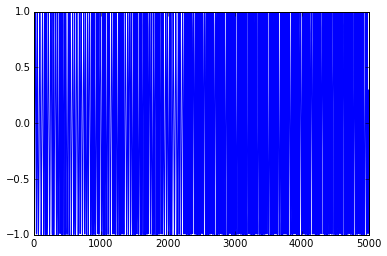

In [18]:
if 1:
    plt.plot(msg1[8000:8000+5000])
    print sig3[:1000]

In [19]:
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()
dusb_in = 1 
dusb_out = 7
din = 6
dout = 6
dusb_out2 = 4
dusb_in2 = 4
try: 
    s = serial.Serial(port='/dev/ttyUSB0') # CHANGE !!!!!!
except:
    try:
        s = serial.Serial(port='/dev/ttyUSB1') # CHANGE !!!!!!
    except:
        s = serial.Serial(port='COM4') # CHANGE !!!!!!
s.setDTR(0)

8 33
0 Microsoft Sound Mapper - Input
1 Microphone (USB PnP Sound Devic
2 Microphone (VIA HD Audio(Compat
3 Microsoft Sound Mapper - Output
4 Digital Audio (HDMI) (2- High D
5 Speakers (VIA HD Audio(Compatib
6 Headphone (VIA HD Audio(Compati
7 Speakers (USB PnP Sound Device)


In [20]:
s.setDTR(0)
tmp = []
p = pyaudio.PyAudio()

Qout1 = Queue.Queue()
ctrlQ1 = Queue.Queue()

Qout2 = Queue.Queue()
ctrlQ2 = Queue.Queue()

Qout3 = Queue.Queue()
ctrlQ3 = Queue.Queue()

Qout4 = Queue.Queue()
ctrlQ4 = Queue.Queue()

Qout5 = Queue.Queue()
ctrlQ5 = Queue.Queue()

Qout6 = Queue.Queue()
ctrlQ6 = Queue.Queue()


Qin = Queue.Queue()
cQin = Queue.Queue()
t_rec = threading.Thread(target = record_audio,   args = (Qin, cQin,p, 48000, dusb_in, 512))
t_rec.start()
time.sleep(2)
scale = .15
Qout1.put("KEYON")
Qout1.put(msg1*scale)  # pick the gain that you calibrated in lab 5 part I
Qout1.put("KEYOFF")
Qout1.put("EOT")

Qout2.put("KEYON")
Qout2.put(msg2*scale)  # pick the gain that you calibrated in lab 5 part I
Qout2.put("KEYOFF")
Qout2.put("EOT")

Qout3.put("KEYON")
Qout3.put(msg3*scale)  # pick the gain that you calibrated in lab 5 part I
Qout3.put("KEYOFF")
Qout3.put("EOT")


Qout4.put("KEYON")
Qout4.put(msg4*scale)  # pick the gain that you calibrated in lab 5 part I
Qout4.put("KEYOFF")
Qout4.put("EOT")

Qout5.put("KEYON")
Qout5.put(msg5*scale)  # pick the gain that you calibrated in lab 5 part I
Qout5.put("KEYOFF")
Qout5.put("EOT")

Qout6.put("KEYON")
Qout6.put(msg6*scale)  # pick the gain that you calibrated in lab 5 part I
Qout6.put("KEYOFF")
Qout6.put("EOT")
#"""
play_audio( Qout1 ,ctrlQ1 ,p, 48000 , dusb_out, s, keydelay=0.1)
time.sleep(1)

play_audio( Qout2 ,ctrlQ2 ,p, 48000 , dusb_out, s, keydelay=0.1)
time.sleep(1)
while not Qin.empty():
    tmp.append(Qin.get())
play_audio( Qout3 ,ctrlQ3 ,p, 48000 , dusb_out, s, keydelay=0.1)
time.sleep(1)
#time.sleep(60)
#"""
#"""
play_audio( Qout4 ,ctrlQ4 ,p, 48000 , dusb_out, s, keydelay=0.1)
time.sleep(1)
while not Qin.empty():
    tmp.append(Qin.get())
play_audio( Qout5 ,ctrlQ5 ,p, 48000 , dusb_out, s, keydelay=0.1)
time.sleep(1)
play_audio( Qout6 ,ctrlQ6 ,p, 48000 , dusb_out, s, keydelay=0.1)
time.sleep(1)

#"""
cQin.put('EOT')
time.sleep(3)
while not Qin.empty():
    tmp.append(Qin.get())
sig = tmp


#with Qin.mutex:
#    Qin.queue.clear()
with cQin.mutex:
    cQin.queue.clear()    
with Qout1.mutex:
    Qout1.queue.clear()
with ctrlQ1.mutex:
    ctrlQ1.queue.clear()
with Qout2.mutex:
    Qout2.queue.clear()
with ctrlQ2.mutex:
    ctrlQ2.queue.clear()
with Qout3.mutex:
    Qout3.queue.clear()
with ctrlQ3.mutex:
    ctrlQ3.queue.clear()
with Qout4.mutex:
    Qout4.queue.clear()
with ctrlQ4.mutex:
    ctrlQ4.queue.clear()
with Qout5.mutex:
    Qout5.queue.clear()
with ctrlQ5.mutex:
    ctrlQ5.queue.clear()
with Qout6.mutex:
    Qout6.queue.clear()
with ctrlQ6.mutex:
    ctrlQ6.queue.clear()
p.terminate()

Closed  play thread
Closed  play thread
Closed  play thread
Closed  play thread
Closed  play thread
Closed  play thread
Closed  record thread


In [21]:
if False:
    try:
        try:
            s = serial.Serial(port='/dev/ttyUSB0')
        except:
            s = serial.Serial(port='/dev/ttyUSB1')
        s.setDTR(0)
        #s = serial.Serial(port='COM3')
        #s.setDTR(0)

        Qin = Queue.Queue()
        cQin = Queue.Queue()

        p = pyaudio.PyAudio()
        fs_usb = 48e3

        Transmission.record_audio(Qin, cQin, p, fs_usb, dusb_in, 512)
    

    except NameError:
        print 'ooga booga'
    time.sleep(2)
    cQin.put('EOT')
    time.sleep(2)
    p.terminate()
    s.close()
    recorded = []
    while not (Qin.empty()):
        recorded.append(Qin.get())

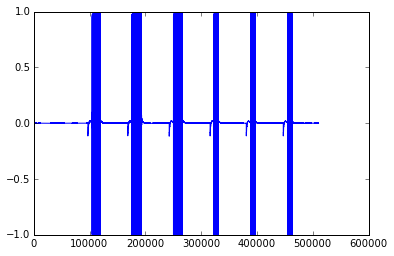

In [22]:
sig = np.array(sig)
psig2 = sig.flatten()
plt.plot(psig2) 

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:187: RuntimeWarning: overflow encountered in long_scalars
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:186: RuntimeWarning: overflow encountered in long_scalars


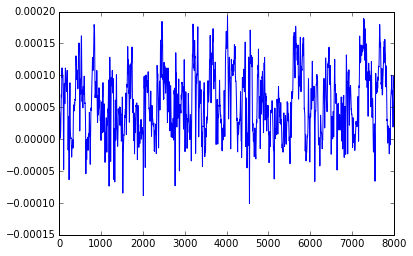

In [23]:
fs = 48000
#sig = tmp

# your code here:
fs = 48000
start = 56000
issig = nc_afsk1200Demod(psig2, fs, f1 =fc-fd, f2 = fc+fd, baud=baud)
plt.plot(issig[start:start+8000])

bindex = PLL(issig, fs=fs, baud = baud)

locs = np.sign(issig)[bindex]
e = bitarray.bitarray([True if x == 1 else False for x in locs])
NRZ = NRZI2NRZ(e)
packets = findPackets(NRZ)

kks = nc_mafsk1200Demod(psig2, baud=baud)#, fc = 2700, fd = 1000)
plloc = mafsk2crossings(kks)
bindex2 = mPLL(plloc, baud=baud)
locs2 = mafsk2barr(kks, indii = bindex2) 
e2 = bitarray.bitarray([True if x == 1 else False for x in locs2])
NRZ2 = NRZI2NRZ(e2)
packets2 = findPackets(NRZ2)

In [24]:
print packets2

[bitarray('01111110010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100000000000000110000000000000000001100000000000000000011110000110000000000000000000000000011110000111100000000000000000000000000000000000011110000000000000000000011110000000000000000001111000000000000000000000000000000000011000000000000000000000000000000000000000000000000000000000011110000000000000000000000000000000000000000000000000000000000000000000000001100000000000000000000001100001100000000000000000000000000111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111100000000000000000000000000000000000000000000000000000000000000000

In [25]:
npack = 0
x = 0
for pkt in packets:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                #x = ax.info
                #break
                npack = npack+1
                print(str(npack)+") |DEST:"+ax.destination[:-1]+" |SRC:"+ax.source + " |DIGI:"+ax.digipeaters+" |",ax.info,"|")
npack = 0
x = 0
for pkt in packets2:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                #x = ax.info
                #break
                npack = npack+1
                print(str(npack)+"AA) |DEST:"+ax.destination[:-1]+" |SRC:"+ax.source + " |DIGI:"+ax.digipeaters+" |",ax.info,"|")


('1) |DEST:APCAL  |SRC:KM6BKZ |DIGI:WIDE1 1WIDE2 1 |', ':1234567890', '|')
failed fcs
('2) |DEST:\x7f\x7f\x7f\x7f\x7f\x7f |SRC:\x7f\x7f\x7f\x7f\x7f\x7f |DIGI:\x7f |', '\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x01', '|')
('3) |DEST:APCAL  |SRC:KM6BKZ |DIGI:WIDE1 1WIDE2 1 |', ':SMSGTE   :@4085966861 PINGPING', '|')
failed fcs
('4) |DEST:\x7f\x7f\x7f\x7f\x7f\x7f |SRC:\x7f\x7f\x7f\x7f\x7f\x7f |DIGI:\x7f |', '\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x03', '|')
('5) |DEST:APCAL  |SRC:KM6BKZ |DIGI:WIDE1 1WIDE2 1 |', '>This is packet number 3', '|')
failed fcs
('6) |DEST:\x7f\x7f\x7f\x7f\x7f\x7f |SRC:\x7f?flng |DIGI:\x1d\x1e |', '\xefq%>\xf3\x92\x02\x00', '|')
failed fcs
('7) |DEST:\x7f\x7f\x7f\x7f\x7f\x7f |SRC:\x7f\x7f\x7f\x7f\x7f\x7f |DIGI:\x7f |', '\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x

('1) |DEST:APCAL  |SRC:KM6BKZ |DIGI:WIDE1 1WIDE2 1 |', '>This is packet number 3', '|')


D:\Anaconda\lib\site-packages\ipykernel\__main__.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:187: RuntimeWarning: overflow encountered in long_scalars


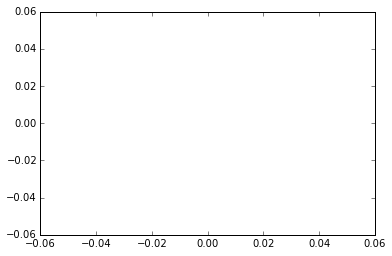

In [26]:
p3 = afsk1200(sig3, baud = 2400)

issig = nc_afsk1200Demod(p3, fs,baud=2400)
#issig = [-1 if x < 0 else 1 for x in (issig-.03)]
plt.plot(issig[start:start+8000])

bindex = PLL(issig, fs=fs, baud = 2400)

locs = np.sign(issig)[bindex]
e = bitarray.bitarray([True if x == 1 else False for x in locs])
NRZ = NRZI2NRZ(e)
packets = findPackets(NRZ)
npack = 0
x = 0
for pkt in packets:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                #x = ax.info
                #break
                npack = npack+1
                print(str(npack)+") |DEST:"+ax.destination[:-1]+" |SRC:"+ax.source + " |DIGI:"+ax.digipeaters+" |",ax.info,"|")

bitarray('00000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100101011010100110001010011010100101110110101011010101110111001001100010010001110100101001110010010011100101011101111001100100100101101001100101100101110101010010010111011110011001001001011010011001011011011101010100111010001110101010101111100000010101100110101100011011000111011110101011011011000111011110101011010101111001010001110100011100111001101110100111101010110100001110011000011000111011010001100100010010000101010010001000100001101000001100111111101111111011111110111111101111111011111110111111101111111011111110111111101111111011111110111111101111111011111110111111101111111011111110111111101111111011111110')
bitarray('000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001001010110101001100010100

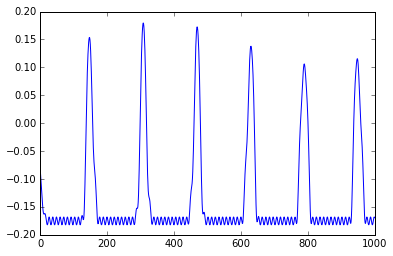

In [27]:
#plt.plot([-1 if x < 0 else 1 for x in (issig-.09)][:1000])
figure()
plt.plot((issig-0)[:1000])
print sig3
print e

In [ ]:
sig3
factor = 2
s3 = mafsk1200(sig2, baud = 1200*factor)
kks = nc_mafsk1200Demod(s3, baud = 1200*factor)
print padded3
plloc = mafsk2crossings(kks)
bindex2 = mPLL(plloc,a=.69, baud=1200*factor)
locs2 = mafsk2barr(kks, indii = bindex2) 
#locs2 = mafsk2barr(kks, centers=10, spacing=20) 
e2 = bitarray.bitarray([True if x == 1 else False for x in locs2])
print len(e2)
print len(sig3)
print len(plloc)
"""
for i in range(len(sig3)):
    try:
        if sig3[i] != e2[i]:
            print i
    except:
        print 33, 'a'
"""
NRZ2 = NRZI2NRZ(e2)
packets2 = findPackets(NRZ2)
print packets2
npack = 0
x = 0
for pkt in packets2:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                #x = ax.info
                #break
                npack = npack+1
                print(str(npack)+"AA) |DEST:"+ax.destination[:-1]+" |SRC:"+ax.source + " |DIGI:"+ax.digipeaters+" |",ax.info,"|")


In [ ]:
print np.where(plloc == 1)
print plloc

In [ ]:
print chr(ord('\x57'))
'W'.encode('hex')

In [ ]:
offs = len(kks[0])-400
lim = 500
ymax = .7
plt.axis([0.0,lim,-ymax,ymax])
plt.plot(np.abs(kks[0])[offs:offs+lim])
figure()
plt.axis([0.0,lim,-ymax,ymax])

plt.plot(np.abs(kks[1])[offs:offs+lim])
figure()
plt.axis([0.0,lim,-ymax,ymax])

plt.plot(np.abs(kks[2])[offs:offs+lim])
figure()
plt.axis([0.0,lim,-ymax,ymax])

plt.plot(np.abs(kks[3])[offs:offs+lim])
figure()
plt.axis([0.0,lim,-ymax,ymax])

plt.plot((kks[3]-kks[2])[offs:offs+lim])
figure()
plt.axis([0.0,lim,-.5,.5])

plt.plot((kks[0]-kks[1])[offs:offs+lim])
figure()
#plt.plot((kks[0]-kks[2])[:50])
print sig3[offs//20:offs//20+lim//20]
print sig3

In [ ]:
gg = kks
x = np.vstack((np.abs(gg[0]), np.abs(gg[1]), np.abs(gg[2]), np.abs(gg[3])))
o = np.argmax(x, axis=0)
o[:80]
np.where(o == 0)

In [ ]:
plloc = mafsk2crossings(kks)
plloc


In [ ]:
lim = 50
np.where((np.abs(kks[0])-np.abs(kks[1])) == 0)
plt.axis([0.0,lim,-.5,.5])
plt.plot((np.abs(kks[0])-np.abs(kks[1]))[1700:1750])
figure()
plt.axis([0.0,lim,-.5,.5])

plt.plot((np.abs(kks[3])-np.abs(kks[2]))[1700:1750])
figure()
plt.axis([0.0,lim,-.5,.5])

#plt.plot((np.abs(kks[3])-np.abs(kks[2]))[1700:1750])
w = np.amax(np.vstack((np.abs((np.abs(kks[3])-np.abs(kks[2]))), np.abs((np.abs(kks[0])-np.abs(kks[1]))))), axis = 0)
#figure()
plt.plot(w[1700:1750])
w[1700:1750]